To deal with the large number of Category, Title and Entity maybe its worth looking into if they are related i.e. does one Title imply that the ad will be of a particular Category. Similiarly, does the Ad being of a particular Entity imply that it will be of a particular Category. For this I am using Contigency table and Chi-square test (refernce: http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html)

In [57]:
# Imports
# pandas
import pandas as pd
from pandas import Series,DataFrame
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gc
import seaborn as sns
p = sns.color_palette()
%matplotlib inline

<b>Topics</b>

In [58]:
try:del events
except:pass;gc.collect()

topics = pd.read_csv('./data/documents_topics.csv')
print('Columns:',topics.columns.tolist())
print('Number of unique topics:', len(topics.topic_id.unique()))

topics.head()

('Columns:', ['document_id', 'topic_id', 'confidence_level'])
('Number of unique topics:', 300)


,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


Number of topics that appear more than 10000 times: 201
Number of topics that appear more than 50000 times: 86
Number of topics that appear more than 100000 times: 22
Number of topics that appear more than 200000 times: 3


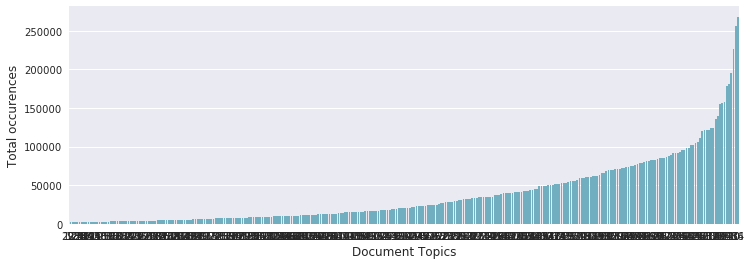

In [59]:
topic_ids = topics.groupby('topic_id')['confidence_level'].count().sort_values()

for i in [10000, 50000, 100000, 200000]:
    print('Number of topics that appear more than {} times: {}'
          .format(i, (topic_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(topic_ids.index, topic_ids.values, order=topic_ids.index, alpha=1, color=p[5])
plt.xlabel('Document Topics', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()
del(topic_ids)

Should we just consider topics who occur may be more than lets say 100000 times (like we did for words in the Naive Bayes classifier?) OR should we check if topics (and entities) are correlated with categories. If they are then we can ignore them since categories would act as their proxy.

<b>Categories</b>

In [60]:
categories = pd.read_csv('./data/documents_categories.csv',  dtype={"document_id": int})

('Columns:', ['document_id', 'category_id', 'confidence_level'])
('Number of unique categories:', 97)
Number of categories that appear more than 1000 times: 88
Number of categories that appear more than 10000 times: 65
Number of categories that appear more than 50000 times: 35
Number of categories that appear more than 100000 times: 15


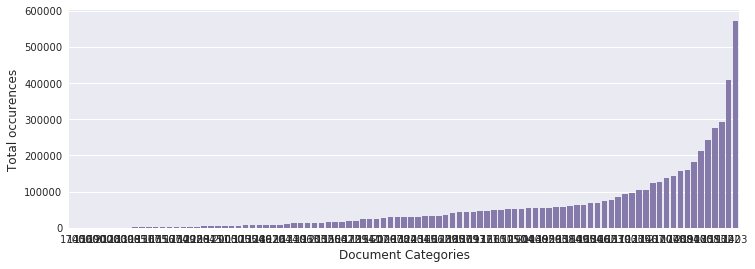

In [61]:
print('Columns:', categories.columns.tolist())
print('Number of unique categories:', len(categories.category_id.unique()))

cat_ids = categories.groupby('category_id')['confidence_level'].count().sort_values()

for i in [1000, 10000, 50000, 100000]:
    print('Number of categories that appear more than {} times: {}'
          .format(i, (cat_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(cat_ids.index, cat_ids.values, order=cat_ids.index, alpha=1, color=p[3])
plt.xlabel('Document Categories', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()
del(cat_ids)

<b>Entities</b>

In [97]:
entities = pd.read_csv('./data/documents_entities.csv',  dtype={"document_id": int})

In [100]:
print('Columns:', entities.columns.tolist())
print('Number of unique entities:', len(entities.entity_id.unique()))

cat_ids = entities.groupby('entity_id')['confidence_level'].count().sort_values()

for i in [1, 5, 10, 100, 1000, 10000, 50000, 100000, 150000, 300000,600000,900000,100000,1100000]:
    print('Number of entities that appear more than {} times: {}'
          .format(i, (cat_ids > i).sum()))

#plt.figure(figsize=(12, 4))
#sns.barplot(cat_ids.index, cat_ids.values, order=cat_ids.index, alpha=1, color=p[3])
#plt.xlabel('Document Entities', fontsize=12)
#plt.ylabel('Total occurences', fontsize=12)
#plt.show()
print ('exactly 1 time {}'.format(((cat_ids == 1).sum())))
print ('exactly 0 time {}'.format(((cat_ids == 0).sum())))
del(cat_ids)

('Columns:', ['document_id', 'entity_id', 'confidence_level'])
('Number of unique entities:', 1326009)
Number of entities that appear more than 1 times: 360909
Number of entities that appear more than 5 times: 89715
Number of entities that appear more than 10 times: 47561
Number of entities that appear more than 100 times: 4831
Number of entities that appear more than 1000 times: 310
Number of entities that appear more than 10000 times: 17
Number of entities that appear more than 50000 times: 3
Number of entities that appear more than 100000 times: 3
Number of entities that appear more than 150000 times: 0
Number of entities that appear more than 300000 times: 0
Number of entities that appear more than 600000 times: 0
Number of entities that appear more than 900000 times: 0
Number of entities that appear more than 100000 times: 3
Number of entities that appear more than 1100000 times: 0
exactly 1 time 965100
exactly 0 time 0


In [101]:
def confidence_max(topics):
    topics_grouped = topics.groupby(['document_id'], sort=False).agg({'confidence_level':'max'})
    topics_grouped = topics_grouped.reset_index()
    topics_grouped = topics_grouped.rename(columns={'confidence_level':'confidence_max'})
    topics_grouped = topics_grouped.drop_duplicates(subset=['document_id'])
    topics = pd.merge(topics, topics_grouped, how='left', on=['document_id'])
    del(topics_grouped)
    topics = topics[topics['confidence_level'] == topics['confidence_max']]
    topics.drop('confidence_level', axis=1, inplace=True)
    topics.drop('confidence_max', axis=1, inplace=True)
    topics = topics.drop_duplicates(subset=['document_id'])
    return topics

In [ ]:
topics = confidence_max(topics)

In [66]:
topics.head()

,document_id,topic_id
0,1595802,140
4,1524246,113
10,1617787,113
16,1615583,89
18,1615460,260


In [67]:
categories = confidence_max(categories)

In [68]:
categories.category_id = categories.category_id.apply(str)

In [69]:
topics.topic_id = topics.topic_id.apply(str)

In [103]:
categories.shape

(2828649, 2)

In [71]:
topics.shape

(2495423, 2)

In [72]:
topics.head()

,document_id,topic_id
0,1595802,140
4,1524246,113
10,1617787,113
16,1615583,89
18,1615460,260


In [73]:
# Outerjoin
topics_cat = pd.merge(topics, categories, how='outer', left_on = 'document_id', right_on = 'document_id')

In [74]:
del(topics)

In [51]:
#cat_dummies = pd.get_dummies(topics_cat.category_id).to_sparse(fill_value=0)

In [52]:
#topics_cat.drop('category_id', axis=1, inplace=True)

In [75]:
topics_cat.drop('document_id', axis=1, inplace=True)

In [54]:
#topics_cat = pd.concat([topics_cat, cat_dummies], axis=1, join='inner')

In [55]:
#del(cat_dummies)

In [77]:
ct = pd.crosstab(topics_cat.topic_id, topics_cat.category_id)
#topics_cat = topics_cat.groupby(by='topic_id', sort=False).agg(sum).reset_index()

In [86]:
ct.shape

(300, 95)

In [84]:
import scipy.stats as stats
stats.chi2_contingency(ct)

(25339983.928967822,
 0.0,
 28106,
 array([[  2.81211773e+00,   7.72838411e+01,   8.34869192e-03, ...,
           1.18412280e+00,   1.45503786e+01,   8.07749858e+01],
        [  2.30286938e+00,   6.32884567e+01,   6.83682151e-03, ...,
           9.69689184e-01,   1.19154404e+01,   6.61473876e+01],
        [  2.75360834e+01,   7.56758608e+02,   8.17498766e-02, ...,
           1.15948575e+01,   1.42476410e+02,   7.90943681e+02],
        ..., 
        [  2.73002123e+01,   7.50276294e+02,   8.10496158e-02, ...,
           1.14955372e+01,   1.41255972e+02,   7.84168541e+02],
        [  1.53858012e+00,   4.22839273e+01,   4.56777868e-03, ...,
           6.47863277e-01,   7.96087695e+00,   4.41940201e+01],
        [  1.11267847e+00,   3.05791132e+01,   3.30335024e-03, ...,
           4.68525176e-01,   5.75718891e+00,   3.19604641e+01]]))

In [104]:
entities = pd.read_csv('./data/documents_entities.csv',  dtype={"document_id": int})
entities = confidence_max(entities)

In [105]:
entities_cat = pd.merge(entities, categories, how='outer', left_on = 'document_id', right_on = 'document_id')

In [106]:
del(entities)

In [107]:
entities_cat.drop('document_id', axis=1, inplace=True)

In [108]:
ct = pd.crosstab(entities_cat.entity_id, entities_cat.category_id)

In [109]:
ct.shape

(509644, 95)

In [110]:
stats.chi2_contingency(ct)

(91072921.430378228,
 0.0,
 47906442,
 array([[  6.16967290e-04,   2.17570011e-02,   5.74457439e-07, ...,
           2.52761273e-04,   3.25545031e-03,   2.75952120e-02],
        [  1.23393458e-03,   4.35140021e-02,   1.14891488e-06, ...,
           5.05522547e-04,   6.51090062e-03,   5.51904240e-02],
        [  6.16967290e-04,   2.17570011e-02,   5.74457439e-07, ...,
           2.52761273e-04,   3.25545031e-03,   2.75952120e-02],
        ..., 
        [  6.16967290e-04,   2.17570011e-02,   5.74457439e-07, ...,
           2.52761273e-04,   3.25545031e-03,   2.75952120e-02],
        [  1.85090187e-03,   6.52710032e-02,   1.72337232e-06, ...,
           7.58283820e-04,   9.76635093e-03,   8.27856360e-02],
        [  2.46786916e-03,   8.70280042e-02,   2.29782976e-06, ...,
           1.01104509e-03,   1.30218012e-02,   1.10380848e-01]]))

P-value is 0 for both Title-Category relationship and Entity-